In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
data_t= !unzip '/content/drive/MyDrive/training/asl_alphabet_train.zip'

Mounted at /content/drive


In [10]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import models
from keras.models import Sequential
from keras import layers
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc



In [3]:

DATA_DIR = '/content/asl_alphabet_train/asl_alphabet_train'

# Initialize lists to store images and labels
labels = []
imagg = []

# Create a dictionary to store the mapping from class number to alphabet label
class_map = {dir_: idx for idx, dir_ in enumerate(sorted(os.listdir(DATA_DIR)))}

for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):

        img_ = os.path.join(DATA_DIR, dir_, img_path)
        # Load images as numpy array
        img = cv2.imread(img_)
        imagg.append(img)

        # Get the class number using the dictionary
        classnum = class_map[dir_]
        labels.append(classnum)

# Store images and labels as numpy arrays
np.save('_data', np.array(imagg))
np.save('_labels', np.array(labels))

# Create a pickle file to save the data
with open('data.pickle', 'wb') as f:
    pickle.dump({'data': imagg, 'labels': labels}, f)





In [4]:
data=np.load('_data.npy')
labels=np.load('_labels.npy')




In [5]:
#splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

In [6]:
x_train, x_test=x_train / 255.0, x_test / 255.0

In [7]:
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(29))

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
533/533 [==============================] - 6s 9ms/step - loss: 1.5824 - accuracy: 0.5203 - val_loss: 0.6181 - val_accuracy: 0.7788
Epoch 2/10
533/533 [==============================] - 5s 9ms/step - loss: 0.3072 - accuracy: 0.8982 - val_loss: 0.1867 - val_accuracy: 0.9392
Epoch 3/10
533/533 [==============================] - 4s 8ms/step - loss: 0.1391 - accuracy: 0.9561 - val_loss: 0.1021 - val_accuracy: 0.9681
Epoch 4/10
533/533 [==============================] - 5s 8ms/step - loss: 0.0959 - accuracy: 0.9693 - val_loss: 0.0565 - val_accuracy: 0.9803
Epoch 5/10
533/533 [==============================] - 5s 9ms/step - loss: 0.0590 - accuracy: 0.9823 - val_loss: 0.1097 - val_accuracy: 0.9681
Epoch 6/10
533/533 [==============================] - 4s 8ms/step - loss: 0.0492 - accuracy: 0.9848 - val_loss: 0.0193 - val_accuracy: 0.9953
Epoch 7/10
533/533 [==============================] - 5s 8ms/step - loss: 0.0446 - accuracy: 0.9866 - val_loss: 0.0290 - val_accuracy: 0.9918
Epoch 

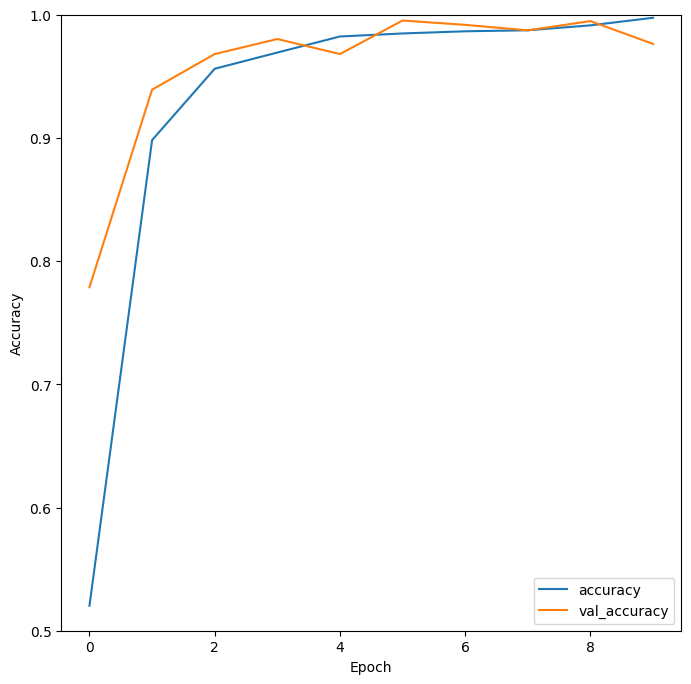

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.savefig("output_report.png")

134/134 [==============================] - 1s 3ms/step


<ipython-input-11-1dc2d6eae43b>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


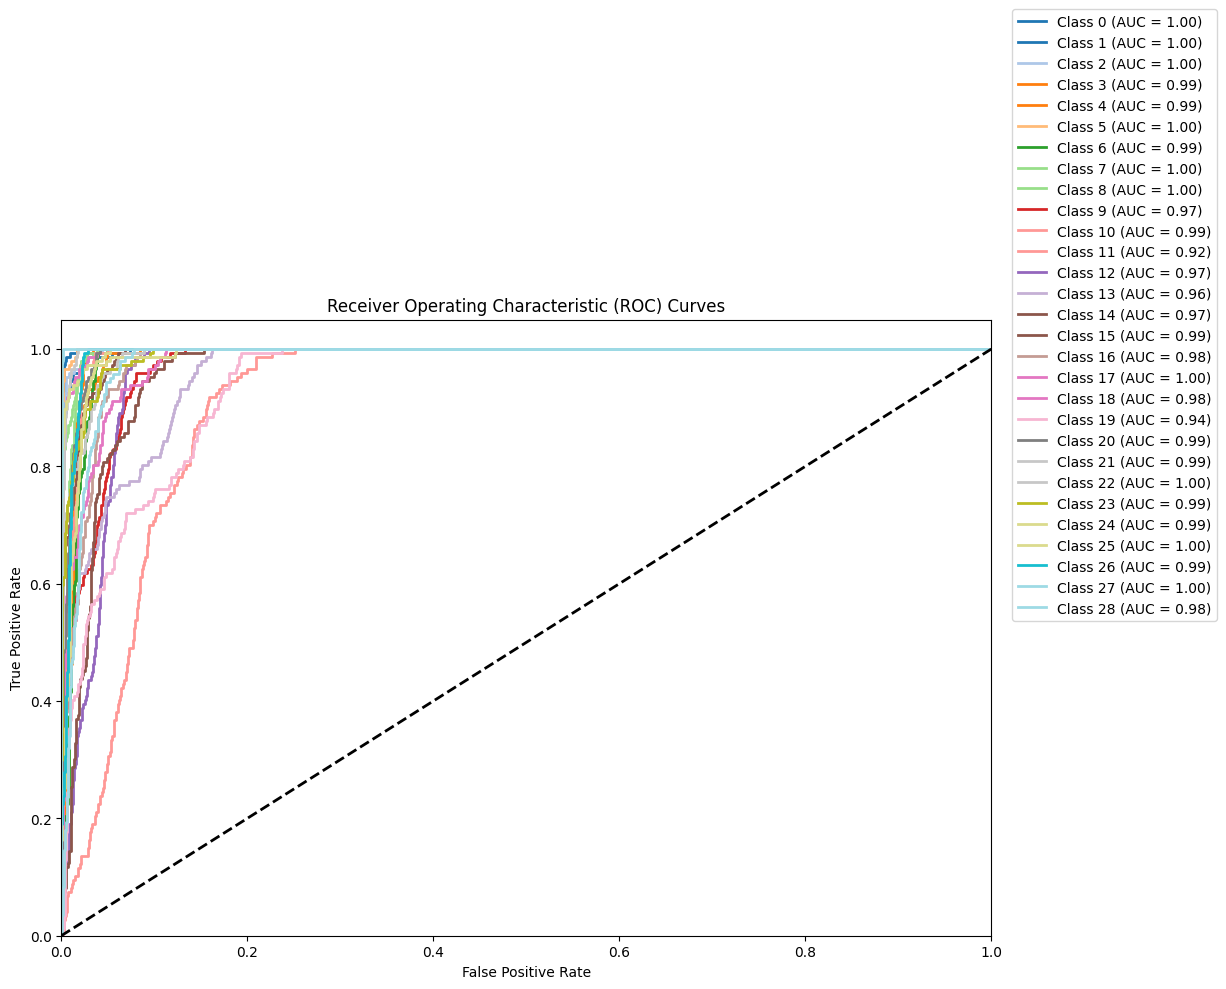

In [11]:
#converts  multi-class labels to a one-hot encoded format required
y_test_onehot = label_binarize(y_test, classes=np.arange(29))

# Make predictions (probabilities) on the test data
y_pred_proba = model.predict(x_test)

# Initialize variables to store ROC curves and AUC scores
fpr = dict()#False pos
tpr = dict()#True pos
roc_auc = dict()#ROC
n_classes = 29

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab20', n_classes)

for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5))
plt.show()

In [12]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

1/1 [==============================] - 0s 25ms/step


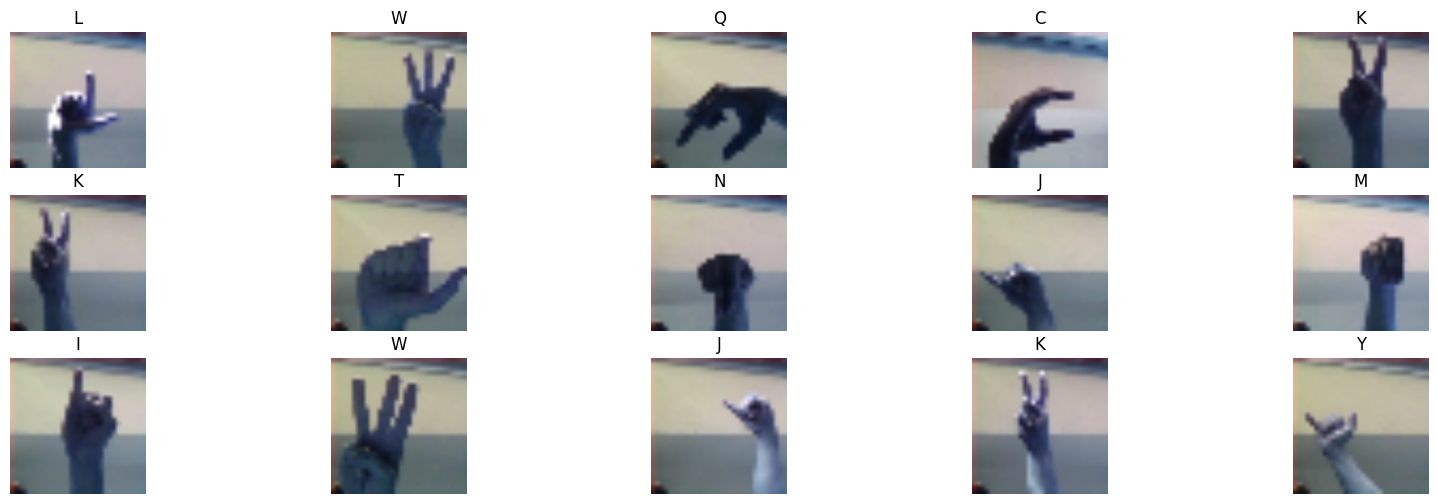

In [13]:
plt.figure(figsize=(20, 6))
for i in range(15):
    # Select a random index
    random_index = random.randint(0, len(x_test) - 1)

    # Resize the selected image
    x_tet = tf.image.resize(x_test[random_index], (175, 175))

    # Predict the class of the selected image
    pred = model.predict(x_test[random_index].reshape(1, 32, 32, 3))
    predicted_class = np.argmax(pred)

    # Get the corresponding key (label) from the class_map
    key = [k for k, v in class_map.items() if v == predicted_class][0]

    # Plot the image
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_tet)
    plt.title(key)
    plt.axis("off")

plt.show()